In [1]:
from PoseClasses import *
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
sns.set_context('talk', font_scale=1)
%reload_ext autoreload
%autoreload 2

# Data Analysis

In [2]:
#the path and posefiles
path = '/Users/luca/Box/Spinal Stim/Poses/SpinalStim--2020-05-21_v1'
# path = '/home/l_lonini01/SpinalStim/DLC/SpinalStim--2020-05-21_v1/train-results'

metadatapath = Path('/Users/luca/Box/Spinal Stim/Metadata/')

#Figures save path
# savepath = '/home/l_lonini01/SpinalStim/DLC/Figs/x/'
# savepath = '/media/fs2-RTO/Spinal Stim/VideoAnalysis/Figs/'
savepath = '/Users/luca/Box/Spinal Stim/Figs/'

In [3]:
posefiles=[c for c in os.listdir(path) if c.endswith('.h5')]
print(len(posefiles))

22


In [4]:
metadata = pd.read_excel(metadatapath/'7.9.20_Gaitrite_DLC_Videos.xlsx')
metadata.dropna(axis=0, how='all',inplace=True)
metadata = pd.concat((metadata[['Subject','Session']].fillna(method='ffill'),metadata.iloc[:,2:]),axis=1)
metadata['Brace Condition'] = metadata['Brace Condition'].apply(updatename)
vals = metadata[['Subject','Session','Speed', 'Brace Condition']].values
metadata['Filename'] = ['_'.join(f) for f in vals]

suffix = ['_'.join(f.split('_')[4:]) for f in posefiles]
assert len(np.unique(suffix)) == 1
suffix = np.unique(suffix)[0]
metadata['Filename']=metadata.Filename+'_'+suffix
metadata.head()

,Subject,Session,Speed,Brace Condition,Analyzed in DLC?,Forground Leg,Paretic Leg,GaitRite Raw Data,Filename
0,SS02,3FU,SSV1,No Brace,NaN,R,NaN,NaN,SS02_3FU_SSV1_No Brace_CroppedDLC_resnet50_Spi...
1,SS02,3FU,SSV2,No Brace,NaN,L,NaN,NaN,SS02_3FU_SSV2_No Brace_CroppedDLC_resnet50_Spi...
2,SS02,3FU,SSV3,No Brace,NaN,R,NaN,NaN,SS02_3FU_SSV3_No Brace_CroppedDLC_resnet50_Spi...
3,SS02,3FU,SSV1,Brace,JH,R,NaN,NaN,SS02_3FU_SSV1_Brace_CroppedDLC_resnet50_Spinal...
4,SS02,3FU,SSV2,Brace,JH,L,NaN,NaN,SS02_3FU_SSV2_Brace_CroppedDLC_resnet50_Spinal...


In [5]:
# jj = ['Right Heel','Right Toe']
# df_i = poses.get_joint_data(jj).copy()
# HTx = (df_i.loc[:,(jj[1],['x'])].values - df_i.loc[:,(jj[0],['x'])].values).reshape(-1)
# HTy = (df_i.loc[:,(jj[1],['y'])].values - df_i.loc[:,(jj[0],['y'])].values).reshape(-1)
# HT = np.array([HTx,HTy]).T
# HTdeg = np.arctan2(HT[:,1],HT[:,0])*180/np.pi
# HTdeg = pd.Series(data=HTdeg, index=df_i.index)
# HTdeg_filt = signal.savgol_filter(HTdeg.values,15,3)
# HTdeg_filt = pd.Series(data=HTdeg_filt, index=df_i.index)
# fig,ax = plt.subplots(1,2, figsize=(12,5))
# # ax[0].plot(HTdeg)
# ax[0].set_title(jj)
# ax[0].plot(HTdeg_filt)
# ax[1].plot(HTdeg_filt.diff())
# ax[1].set_title('speed')
# # ax[0].set_xlim([0,2.5])
# # ax[1].set_xlim([0,2.5])
# # pd.Series(data=HT, index=df_i.index.values)
# # df_i.columns = df_i.columns.droplevel()
# # df_i['t'] = df_i.index
# # df_i.loc[:,'x']

In [6]:
posefiles=[c for c in os.listdir(path) if c.endswith('.h5')]
filename = posefiles[4]
print(filename)
print('total available pose files = {}'.format(len(posefiles)))

SS04_Mid_SSV2_Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle1_80000.h5
total available pose files = 22


16.0


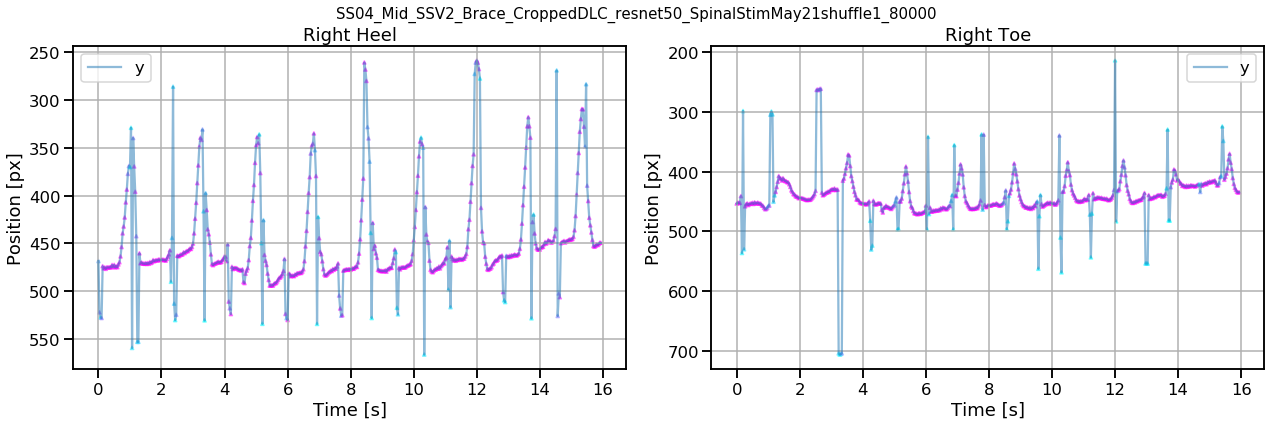

In [8]:
jj = ['Right Heel','Right Toe']
poses = PoseData(path, filename)
print(poses.get_duration())
PA = AnalyzePoses(jj)
PA.plot_joints(poses)

In [22]:
#save figures
for filename in posefiles:
    poses = PoseData(path, filename)
    joints =['Left Heel','Right Heel','Left Toe','Right Toe']
    PA = AnalyzePoses(joints)
    PA.plot_joints(poses,savepath,axis='x')

In [9]:
#CHOOSE SUBJECT TO PLOT
subjid = 'SS02_3FU_SSV3_Brace'
suffix = ['_'.join(f.split('_')[4:]) for f in posefiles]
assert len(np.unique(suffix)) == 1
suffix = np.unique(suffix)[0]
filename = subjid+'_'+suffix

SS02_3FU_SSV3_Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle1_80000.h5 R


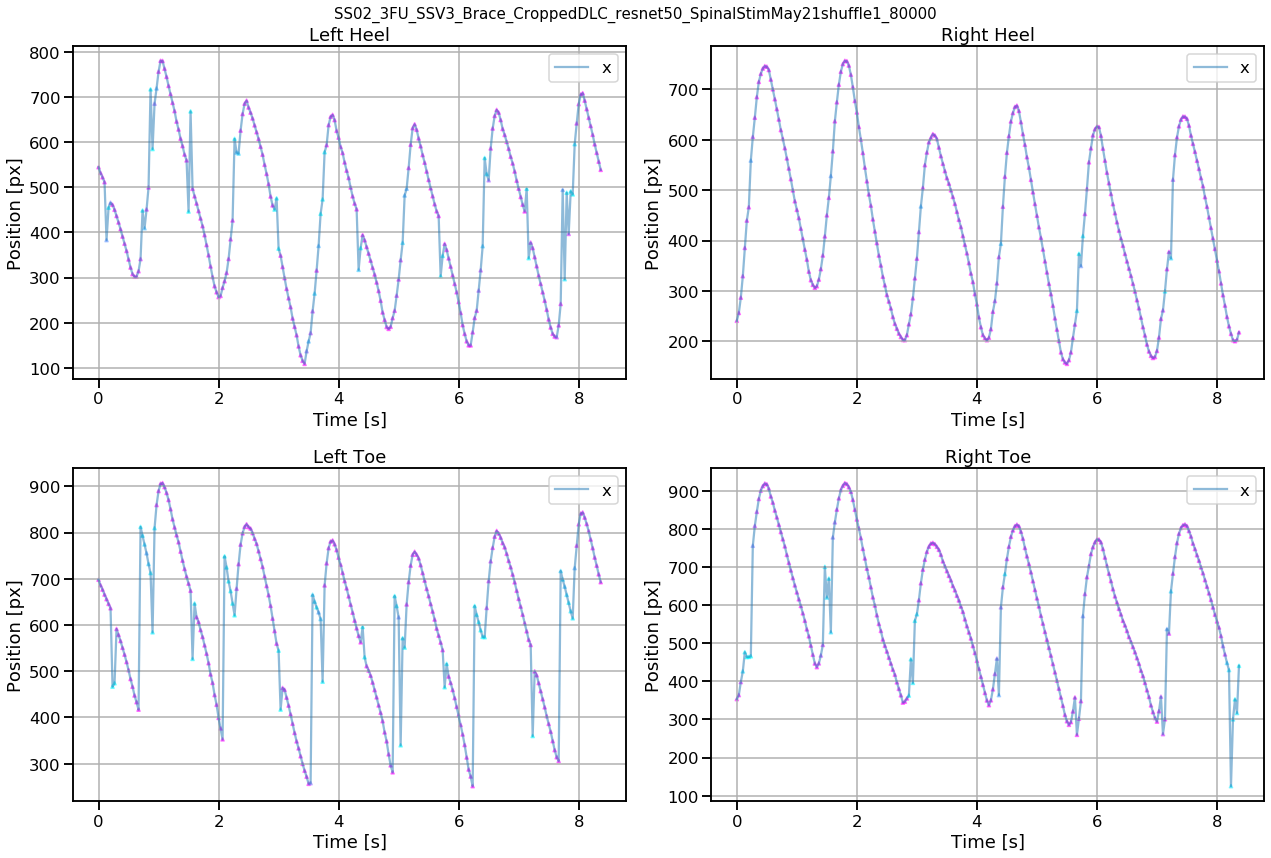

In [10]:
poses = PoseData(path, filename)
direction = metadata.query('Filename==@filename')['Forground Leg'].values[0] #walk direction 
print(filename,direction)
joints =['Left Heel','Right Heel','Left Toe','Right Toe']
PA = AnalyzePoses(joints)
PA.plot_joints(poses, axis='x', xlim=None)

# Extract Swing-Stance times from all subjects
* for each file
    * Load pose data (h5 file)
    * Filter data 
    * for each side (joint)
        * Run HSTO extraction
        * Run Swing/Stance extraction
        * (merge SwSt dataframe)
        * Save SwSt dataframe
    

In [22]:
#loop thru all subject pose files and extract swing/stance
SWST_all = []

for filename in posefiles:
    poses = PoseData(path, filename)
    direction = metadata.query('Filename==@filename')['Forground Leg'].values[0] #walk direction 
    joints =['Left Toe','Right Toe'] #should select the joint with highest cumulative or mean confidence
    Filter = FilterData()
    dfout = Filter.get_filterdata(poses,joints) #the filtered poses
    
    for side in dfout.columns:
        print(filename)
        szf = dfout[side]
        try:
            pksT,pksNT = findHSTO(szf, direction, plotdata=False) #find positive and neg peaks (approx HS, TO)
            swst = swing_stance(pksT,pksNT) # swing and stance times
            #add metadata
            swst['side'] = side.split(' ')[0]
            subjid = '_'
            l = filename.split('_')[0:4]
            subjid = subjid.join(l)
            swst['subj'] = subjid

            SWST_all.append(swst)    
        except:
            f'{filename} - extraction error'


SS02_3FU_SSV1_Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle1_80000.h5
SS02_3FU_SSV1_Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle1_80000.h5
savgol filter fit failed
SS02_3FU_SSV2_Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle1_80000.h5
SS02_3FU_SSV2_Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle1_80000.h5
SS02_3FU_SSV3_Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle1_80000.h5
SS02_3FU_SSV3_Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle1_80000.h5
SS04_Mid_SSV1_Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle1_80000.h5
SS04_Mid_SSV1_Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle1_80000.h5
SS04_Mid_SSV2_Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle1_80000.h5
SS04_Mid_SSV2_Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle1_80000.h5
SS04_Mid_SSV3_Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle1_80000.h5
SS04_Mid_SSV3_Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle1_80000.h5
SS07_Pre_SSV1_No Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle1_80000.h5
SS07_Pre_SSV1_No Brace_

In [23]:
SWST_all=pd.concat(SWST_all)

In [24]:
SWST_all.head()

,dT,type,Type,side,subj
0,0.466667,1.0,Swing,Left,SS02_3FU_SSV1_Brace
1,0.833333,-1.0,Stance,Left,SS02_3FU_SSV1_Brace
2,0.533333,1.0,Swing,Left,SS02_3FU_SSV1_Brace
3,0.933333,-1.0,Stance,Left,SS02_3FU_SSV1_Brace
4,0.466667,1.0,Swing,Left,SS02_3FU_SSV1_Brace


In [25]:
#percent missed
len(SWST_all.loc[SWST_all.Type=='Missed'])/len(SWST_all)

0.003205128205128205

In [26]:
SWST_all=SWST_all.query('Type!="Missed"')

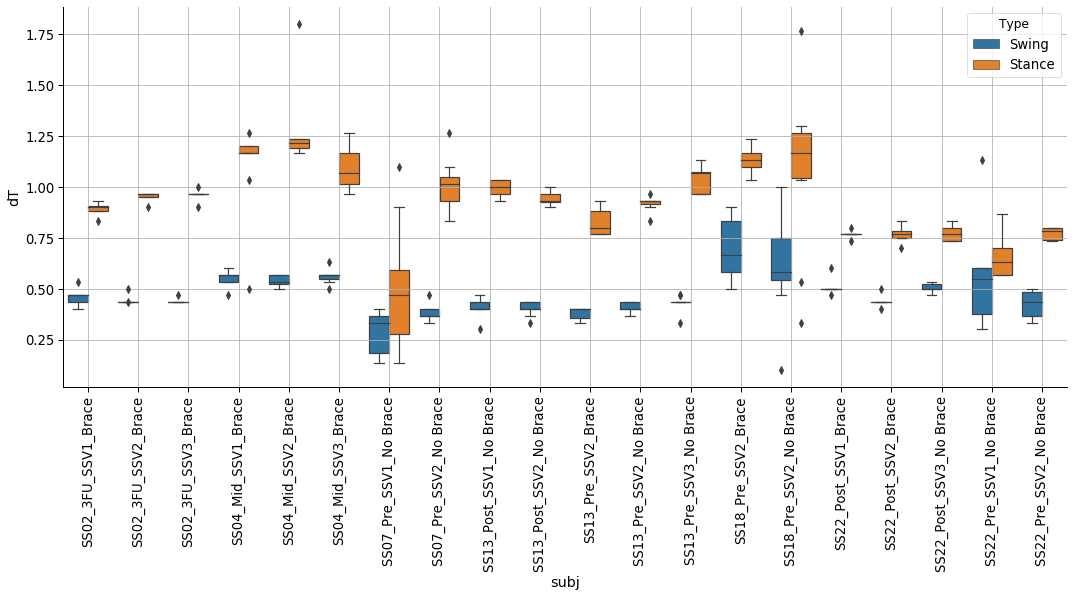

In [27]:
sns.set_context('paper', font_scale=1.5)
fig,ax = plt.subplots(1,1,figsize=(18,7))
ax = sns.boxplot(data=SWST_all.query('side=="Left"'), x='subj',y='dT', hue='Type',ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation='vertical')
sns.despine()
ax.grid()

In [28]:
subjid = 'SS02_3FU_SSV3_Brace'
swing_L = SWST_all.query('(subj==@subjid) & (side=="Left") & (Type=="Swing")').dT.median()
stance_L = SWST_all.query('(subj==@subjid) & (side=="Left") & (Type=="Stance")').dT.median()
swing_R = SWST_all.query('(subj==@subjid) & (side=="Right") & (Type=="Swing")').dT.median()
stance_R = SWST_all.query('(subj==@subjid) & (side=="Right") & (Type=="Stance")').dT.median()
print(f'swing_L = {swing_L}, swing_R = {swing_R}')
print(f'stance_L = {stance_L}, stance_R = {stance_R}')

swing_L = 0.43333333333333324, swing_R = 0.4666666666666668
stance_L = 0.9666666666666668, stance_R = 0.9000000000000004


In [20]:
# DLCtimes = pd.DataFrame()
# DLCtimes['Str']

## Compare to GaitRite

In [29]:
gaitrite = pd.read_excel(metadatapath/'Temporal parameters_Gaitrite_DLC_Videos.xlsx',header=[0])
gaitrite.dropna(axis=0,how='all',inplace=True)
gaitrite = pd.concat((gaitrite[['Subject','Session']].fillna(method='ffill'),gaitrite.iloc[:,2:]),axis=1)
gaitrite['Brace Condition'] = gaitrite['Brace Condition'].apply(updatename)
vals = gaitrite[['Subject','Session','Speed', 'Brace Condition']].values
gaitrite['Filename'] = ['_'.join(f) for f in vals]
gaitrite.set_index(gaitrite.Filename, inplace=True)
gaitrite.head()

,Subject,Session,Speed,Brace Condition,Analyzed in DLC?,Side captured in video,Paretic Leg,# of Labeled Frames,Stride time L,Stride time R,Swing time L,Swing time R,Stance time L,Stance time R,Single Support Time L,Single Support Time R,Double Support Time L,Double Support Time R,Filename
Filename,,,,,,,,,,,,,,,,,,,
SS02_3FU_SSV1_No Brace,SS02,3FU,SSV1,No Brace,SJ 7.30,R,R,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SS02_3FU_SSV1_No Brace
SS02_3FU_SSV2_No Brace,SS02,3FU,SSV2,No Brace,SJ 7.30,L,R,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SS02_3FU_SSV2_No Brace
SS02_3FU_SSV3_No Brace,SS02,3FU,SSV3,No Brace,SJ 7.30,R,R,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SS02_3FU_SSV3_No Brace
SS02_3FU_SSV1_Brace,SS02,3FU,SSV1,Brace,JH,R,R,19.0,1.354,1.339,0.404,0.508,0.951,0.831,0.508,0.404,0.426,0.418,SS02_3FU_SSV1_Brace
SS02_3FU_SSV2_Brace,SS02,3FU,SSV2,Brace,JH,L,R,18.0,1.396,1.400,0.433,0.496,0.964,0.905,0.496,0.433,0.468,0.439,SS02_3FU_SSV2_Brace


In [30]:
len(gaitrite[~gaitrite['Stride time L'].isnull()]) # of subject videos with GaitRite data

33

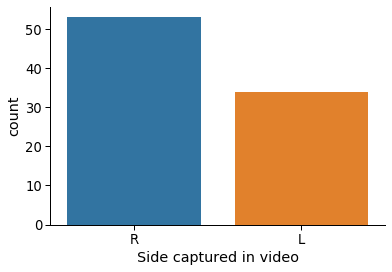

In [31]:
sns.countplot(gaitrite['Side captured in video'])
sns.despine()

In [32]:
swingL_DLC = SWST_all.query('(side=="Left") & (Type=="Swing")').groupby(['subj']).median().drop('type', axis=1).rename(columns={'dT':'Swing time L'})
stanceL_DLC = SWST_all.query('(side=="Left") & (Type=="Stance")').groupby(['subj']).median().drop('type', axis=1).rename(columns={'dT':'Stance time L'})
swingR_DLC = SWST_all.query('(side=="Right") & (Type=="Swing")').groupby(['subj']).median().drop('type', axis=1).rename(columns={'dT':'Swing time R'})
stanceR_DLC = SWST_all.query('(side=="Right") & (Type=="Stance")').groupby(['subj']).median().drop('type', axis=1).rename(columns={'dT':'Stance time R'})

In [33]:
DLCTimes = pd.concat((swingL_DLC,stanceL_DLC,swingR_DLC,stanceR_DLC),axis=1)
DLCTimes.head()

,Swing time L,Stance time L,Swing time R,Stance time R
SS02_3FU_SSV1_Brace,0.466667,0.900000,0.433333,0.933333
SS02_3FU_SSV2_Brace,0.433333,0.966667,NaN,NaN
SS02_3FU_SSV3_Brace,0.433333,0.966667,0.466667,0.900000
SS04_Mid_SSV1_Brace,0.566667,1.166667,0.433333,1.266667
SS04_Mid_SSV2_Brace,0.533333,1.216667,0.433333,1.266667


In [34]:
print(len(DLCTimes)) # of video subjects processed

22


In [35]:
DLCTimes.columns.values

array(['Swing time L', 'Stance time L', 'Swing time R', 'Stance time R'],
      dtype=object)

In [36]:
GaitRiteTimes = gaitrite[DLCTimes.columns].set_index(gaitrite.Filename)
GaitRiteTimes['Side_Video'] = gaitrite['Side captured in video']
GaitRiteTimes.head()

,Swing time L,Stance time L,Swing time R,Stance time R,Side_Video
Filename,,,,,
SS02_3FU_SSV1_No Brace,NaN,NaN,NaN,NaN,R
SS02_3FU_SSV2_No Brace,NaN,NaN,NaN,NaN,L
SS02_3FU_SSV3_No Brace,NaN,NaN,NaN,NaN,R
SS02_3FU_SSV1_Brace,0.404,0.951,0.508,0.831,R
SS02_3FU_SSV2_Brace,0.433,0.964,0.496,0.905,L


In [37]:
StrideTimes = DLCTimes.join(GaitRiteTimes,how='left', lsuffix='_DLC',rsuffix='')
StrideTimes.head()

,Swing time L_DLC,Stance time L_DLC,Swing time R_DLC,Stance time R_DLC,Swing time L,Stance time L,Swing time R,Stance time R,Side_Video
SS02_3FU_SSV1_Brace,0.466667,0.900000,0.433333,0.933333,0.404,0.951,0.508,0.831,R
SS02_3FU_SSV2_Brace,0.433333,0.966667,NaN,NaN,0.433,0.964,0.496,0.905,L
SS02_3FU_SSV3_Brace,0.433333,0.966667,0.466667,0.900000,0.375,1.034,0.554,0.842,R
SS04_Mid_SSV1_Brace,0.566667,1.166667,0.433333,1.266667,0.550,1.154,0.392,1.307,R
SS04_Mid_SSV2_Brace,0.533333,1.216667,0.433333,1.266667,0.528,1.222,0.381,1.358,L


In [38]:
#input dataframe and labels
def scatterplot_2(data,x,y,ax,hue=None,legend=None):
    tol = 0.1
    sns.scatterplot(x, y, data=data, hue=hue, legend=legend, alpha=.7, ax=ax)
    sns.despine()
    xm = min(data[x]); xM = max(data[x])
    ym = min(data[y]); yM = max(data[y])
#     ax.set_xlim([xm-0.25*xm, xM+0.25*xM])
#     ax.set_ylim([ym-0.25*ym, yM+0.25*yM])
    ax.plot([xm,xM],[ym, yM],c='gray',linestyle='--', alpha=.5)

In [39]:
savepath

'/Users/luca/Box/Spinal Stim/Figs/'

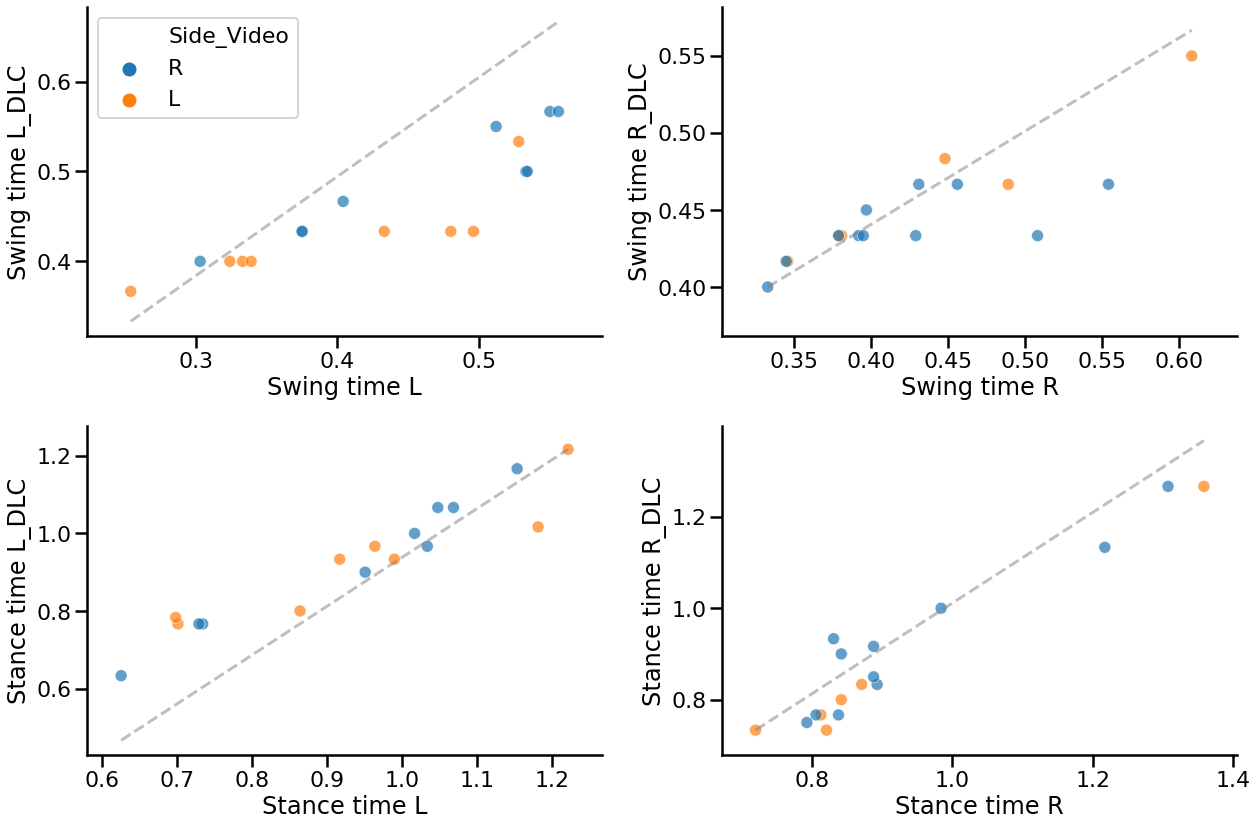

In [40]:
sns.set_context('poster', font_scale=1)
fig,ax = plt.subplots(2,2, figsize=(18,12)); ax= ax.ravel()
huevar = StrideTimes.index #color by subject
huevar = 'Side_Video'
scatterplot_2(data=StrideTimes, x='Swing time L',y='Swing time L_DLC', ax=ax[0], hue=huevar, legend='brief')
scatterplot_2(data=StrideTimes, x='Swing time R',y='Swing time R_DLC', ax=ax[1], hue=huevar)
scatterplot_2(data=StrideTimes, x='Stance time L',y='Stance time L_DLC', ax=ax[2], hue=huevar)
scatterplot_2(data=StrideTimes, x='Stance time R',y='Stance time R_DLC', ax=ax[3], hue=huevar)
plt.tight_layout()
# plt.savefig(savepath+'/Scatter.jpg', dpi=300)

In [42]:
# StrideTimes['Swing time L_DLC']

In [28]:
StrideTimes.columns

Index(['Swing time L_DLC', 'Stance time L_DLC', 'Swing time R_DLC',
       'Stance time R_DLC', 'Swing time L', 'Stance time L', 'Swing time R',
       'Stance time R', 'Side_Video'],
      dtype='object')

# Error analysis

In [55]:
err = pd.DataFrame(columns=StrideTimes.columns[4:])
err_perc = err.copy()
for i in range(4):
    err.iloc[:,i]=np.abs(StrideTimes.iloc[:,i] - StrideTimes.iloc[:,i+4])
    err_perc.iloc[:,i] = err.iloc[:,i]/StrideTimes.iloc[:,i+4]*100
err_perc[err_perc>15].dropna(how='all')

,Swing time L,Stance time L,Swing time R,Stance time R,Side_Video
SS02_3FU_SSV1_Brace,15.511551,NaN,NaN,NaN,NaN
SS02_3FU_SSV3_Brace,15.555556,NaN,15.764140,NaN,NaN
SS07_Pre_SSV2_No Brace,44.356955,NaN,NaN,NaN,NaN
SS13_Post_SSV1_No Brace,32.013201,NaN,NaN,NaN,NaN
SS13_Post_SSV2_No Brace,23.456790,NaN,NaN,NaN,NaN
SS13_Pre_SSV2_Brace,20.120120,NaN,NaN,NaN,NaN
SS13_Pre_SSV2_No Brace,17.994100,NaN,NaN,NaN,NaN
SS13_Pre_SSV3_No Brace,15.555556,NaN,NaN,NaN,NaN
SS22_Pre_SSV1_No Brace,NaN,NaN,20.120120,NaN,NaN
SS22_Pre_SSV2_No Brace,NaN,NaN,20.423892,NaN,NaN


In [227]:
StrideTimes.loc[['SS02_3FU_SSV3_Brace']]

,Swing time L_DLC,Stance time L_DLC,Swing time R_DLC,Stance time R_DLC,Swing time L,Stance time L,Swing time R,Stance time R,Side_Video
subj,,,,,,,,,
SS02_3FU_SSV3_Brace,0.116667,0.95,0.466667,0.933333,0.375,1.034,0.554,0.842,R


In [228]:
err_perc

,Swing time L,Stance time L,Swing time R,Stance time R,Side_Video
subj,,,,,
SS02_3FU_SSV1_Brace,0.990099,1.857694,11.417323,8.303249,NaN
SS02_3FU_SSV2_Brace,7.621247,0.276625,0.806452,41.068140,NaN
SS02_3FU_SSV3_Brace,68.888889,8.123791,15.764140,10.847189,NaN
SS04_Mid_SSV1_Brace,75.757576,45.118429,2.040816,0.535578,NaN
SS04_Mid_SSV2_Brace,11.616162,5.019094,8.136483,48.453608,NaN
SS04_Mid_SSV3_Brace,10.071942,1.399491,3.442485,1.342098,NaN
SS07_Pre_SSV1_No Brace,NaN,NaN,NaN,NaN,NaN
SS07_Pre_SSV2_No Brace,18.110236,11.167513,17.763158,22.858303,NaN
SS13_Post_SSV1_No Brace,10.011001,47.558178,8.275329,6.981982,NaN


In [48]:
err.describe().loc[['mean','50%','std']]

,Swing time L,Stance time L,Swing time R,Stance time R
mean,0.049431,0.041706,0.048902,0.052863
50%,0.058333,0.032667,0.053000,0.043000
std,0.031121,0.041429,0.022794,0.026289


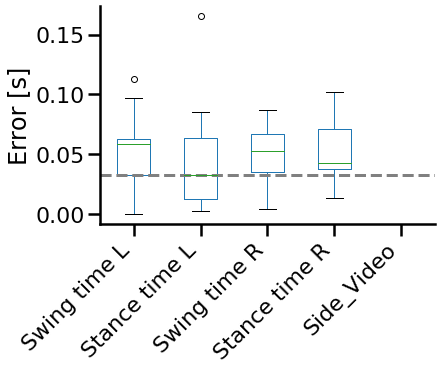

In [50]:
ax = err.plot(kind='box')
aax = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
aax = ax.set_ylabel('Error [s]')
plt.axhline(y=0.033, color='gray', linestyle='--')
sns.despine()

In [51]:
err_perc.describe().loc[['mean','50%','std']]

,Swing time L,Stance time L,Swing time R,Stance time R
mean,13.702153,4.635306,11.847300,5.768280
50%,12.634409,4.450500,13.350126,5.422446
std,11.742110,4.222996,5.938509,2.857937


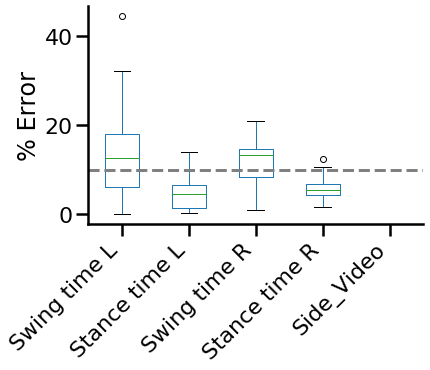

In [53]:
ax = err_perc.plot(kind='box')
aax = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
aax = ax.set_ylabel('% Error')
plt.axhline(y=10, color='gray', linestyle='--')
sns.despine()

In [33]:
#skeleton
skeleton_files = os.listdir(path + '/skeleton')

In [34]:
(skeleton_files[0])

'SS02_3FU_SSV1_Brace_CroppedDLC_resnet101_SpinalStimMay21shuffle1_100000_skeleton.h5'

In [35]:
skeleton = pd.read_hdf(path+'/skeleton/'+Path(skeleton_files[0]).stem+'.h5')
skeleton.head()

Left Hip_Left Knee                        Left Knee_Left Ankle              \
              length orientation likelihood               length orientation   
0           3.481062   40.935488   0.998163           211.886577   78.544557   
1           4.085009   65.532842   0.997517           211.227637   79.809868   
2         145.423128   46.318361   0.998552           208.630877   82.101017   
3         137.618170   49.260799   0.998246           209.832891   85.205406   
4           4.043991   65.794473   0.998602           210.902642   86.548322   

             Left Toe_Left Heel                        Left Heel_Left Ankle  \
  likelihood             length orientation likelihood               length   
0   0.998467         133.730062  166.429841   0.999652            70.506018   
1   0.998978         133.182777  169.459488   0.999563            72.368388   
2   0.998456         132.890114  170.549610   0.999497            74.225619   
3   0.997393         135.001238  170.567577   0.999445            76.551651   
4   0.998113         133.768876  170.793265   0.999132            76.916323   

   ... Right Hip_Right Knee Right Knee_Right Ankle                         \
   ...           likelihood                 length orientation likelihood   
0  ...             0.998112             258.421394  110.378912   0.996349   
1  ...             0.997578             260.890951  111.853555   0.993873   
2  ...             0.999135             261.059623  113.207037   0.994086   
3  ...             0.997991             263.824546  114.197379   0.995344   
4  ...             0.997655             264.107083  114.960839   0.998534   

  Right Toe_Right Heel                        Right Heel_Right Ankle  \
                length orientation likelihood                 length   
0           150.894649  176.916241   0.997828              74.506004   
1           153.258879  177.278070   0.996922              74.315609   
2           152.689388  177.909837   0.998001              75.091952   
3           154.827666  180.050504   0.998168              74.845272   
4           151.968147  183.198088   0.990491              75.245790   

                          
  orientation likelihood  
0  300.761922   0.996349  
1  299.550105   0.993873  
2  300.302879   0.994086  
3  303.965619   0.995344  
4  305.931551   0.998534  

[5 rows x 24 columns]

In [36]:
anglesDLC = skeleton.loc[:,(slice(None),['orientation'])]
anglesDLC.columns = anglesDLC.columns.droplevel(1) 
anglesDLC.columns

Index(['Left Hip_Left Knee', 'Left Knee_Left Ankle', 'Left Toe_Left Heel',
       'Left Heel_Left Ankle', 'Right Hip_Right Knee',
       'Right Knee_Right Ankle', 'Right Toe_Right Heel',
       'Right Heel_Right Ankle'],
      dtype='object')

In [37]:
list(StrideTimes.columns.values)[4:]

['Swing time L',
 'Stance time L',
 'Swing time R',
 'Stance time R',
 'Side_Video']

In [195]:
#input raw x-y data to plot
def scatterplot_2(xdata,ydata,ax,xlabel=None,ylabel=None):
    tol = 0.1
    ax.scatter(xdata,ydata,alpha=.7)
    xm = min(xdata); xM = max(xdata)
    ym = min(ydata); yM = max(ydata)
#     ax.set_xlim([xm-tol*xm, xM+tol*xM])
#     ax.set_ylim([ym-tol*ym, yM+tol*yM])
    ax.plot([xm,xM],[ym, yM],c='gray',linestyle='--', alpha=.5)
    sns.despine()
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

In [309]:
# fig,ax = plt.subplots(2,2, figsize=(18,12)); ax= ax.ravel()
# scatterplot_2(StrideTimes['Swing time L'], StrideTimes['Swing time L_DLC'], ax[0], xlabel='Swing time L',
#              ylabel='Swing time L_DLC')
# scatterplot_2(StrideTimes['Stance time L'], StrideTimes['Stance time L_DLC'], ax[1], xlabel='Stance time L',
#              ylabel='Stance time L_DLC')
# scatterplot_2(StrideTimes['Swing time R'], StrideTimes['Swing time R_DLC'], ax[2], xlabel='Swing time R',
#              ylabel='Swing time R_DLC')
# scatterplot_2(StrideTimes['Stance time R'], StrideTimes['Stance time R_DLC'], ax[3], xlabel='Stance time R',
#              ylabel='Stance time R_DLC')


In [313]:
# fig,ax = plt.subplots(2,2, figsize=(18,12)); ax= ax.ravel()
# scatterplot_2(StrideTimes['Swing time L'], StrideTimes['Swing time L_DLC'], ax[0], xlabel='Swing time L',
#              ylabel='Swing time L_DLC')
# scatterplot_2(StrideTimes['Stance time L'], StrideTimes['Stance time L_DLC'], ax[1], xlabel='Stance time L',
#              ylabel='Stance time L_DLC')
# scatterplot_2(StrideTimes['Swing time R'], StrideTimes['Swing time R_DLC'], ax[2], xlabel='Swing time R',
#              ylabel='Swing time R_DLC')
# scatterplot_2(StrideTimes['Stance time R'], StrideTimes['Stance time R_DLC'], ax[3], xlabel='Stance time R',
#              ylabel='Stance time R_DLC')


# One off run

In [5]:
%matplotlib inline

In [6]:
subjid = 'SS02_3FU_SSV3_Brace'

SS02_3FU_SSV3_Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle1_80000.h5 R


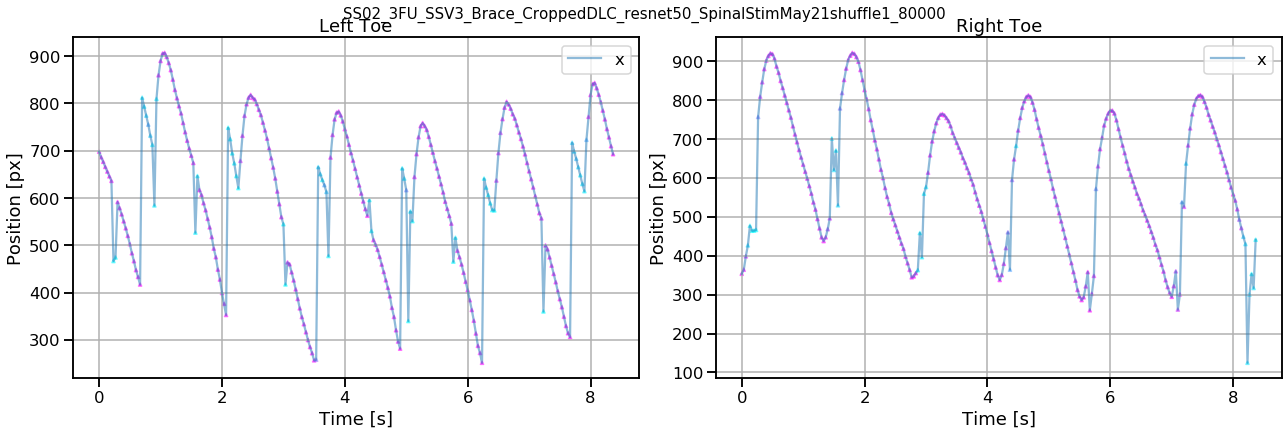

In [7]:
filename = subjid+'_'+suffix
poses = PoseData(path, filename)
direction = metadata.query('Filename==@filename')['Forground Leg'].values[0] #walk direction 
print(filename,direction)
#plot raw data
joints =['Left Toe','Right Toe']
PA = AnalyzePoses(joints)
PA.plot_joints(poses, axis='x', xlim=None)

In [8]:
truth = pd.read_csv('/Users/luca/Box/Spinal Stim/GoldStandard_HSTO/Video_HSTO/Short_SS02_Brace_SSV3_Cropped video.csv')
truth

,RTO,RHS,LTO,LHS
0,1.34,1.90,2.07,2.50
1,2.80,3.34,3.54,3.94
2,4.20,4.70,4.90,5.30
3,5.54,6.07,6.24,6.71


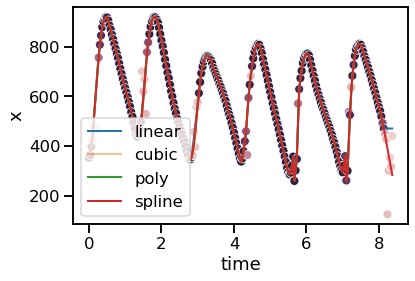

In [9]:
# %matplotlib qt

s = poses.get_joint_data('Right Toe')
s.columns = s.columns.droplevel(0)
s = s[['x','likelihood']]
s['time'] = s.index
ax = sns.scatterplot(x='time',y='x',data=s, hue='likelihood', legend=False)
s.loc[s.likelihood < .6,'x'] = np.nan
#comparing different interpolation methods
s.interpolate(method='linear').plot(x='time',y='x',ax=ax, linewidth=2, label='linear')
s.interpolate(method='cubic').plot(x='time',y='x',ax=ax, linewidth=2, alpha=.5, label='cubic')
s.interpolate(method='polynomial', order=2).plot(x='time',y='x',ax=ax, linewidth=2, label='poly')
s.interpolate(method='spline', order=3).plot(x='time',y='x',ax=ax, linewidth=2, label='spline')

In [10]:
s.interpolate(method='spline', order=3)

coords,x,likelihood,time
0.000000,353.501984,0.998566,0.000000
0.033333,363.972534,0.930508,0.033333
0.066667,398.275330,0.859336,0.066667
0.100000,446.684206,0.142139,0.100000
0.133333,504.245430,0.060356,0.133333
...,...,...,...
8.233333,391.111485,0.102209,8.233333
8.266667,363.801486,0.092421,8.266667
8.300000,336.522548,0.036778,8.300000
8.333333,309.565171,0.100130,8.333333


In [19]:
sns.set_context('paper',font_scale=1.5)
Filter = FilterData()
joints =['Left Toe','Right Toe'] #make a copy of the data
# joints =['Left Heel','Right Heel'] #make a copy of the data
dfout = Filter.get_filterdata(poses,joints) #the filtered poses
dfout.head()

coords             x  likelihood
0.000000  697.888184    0.999394
0.033333  685.964722    0.997874
0.066667  676.500366    0.999695
0.100000  665.721191    0.999344
0.133333  655.852966    0.999084
...              ...         ...
8.233333  766.194824    0.999632
8.266667  745.780151    0.999472
8.300000  728.178711    0.999773
8.333333  709.534851    0.999927
8.366667  692.589661    0.999898

[252 rows x 2 columns]
coords             x  likelihood
0.000000  353.501984    0.998566
0.033333  363.972534    0.930508
0.066667  398.275330    0.859336
0.100000  446.684206    0.142139
0.133333  504.245430    0.060356
...              ...         ...
8.233333  391.111485    0.102209
8.266667  363.801486    0.092421
8.300000  336.522548    0.036778
8.333333  309.565171    0.100130
8.366667  283.219858    0.027323

[252 rows x 2 columns]


,Left Toe,Right Toe
0.000000,-0.097855,-0.175610
0.033333,-0.146979,-0.109297
0.066667,-0.199863,0.033154
0.100000,-0.256332,0.236459
0.133333,-0.316212,0.485330


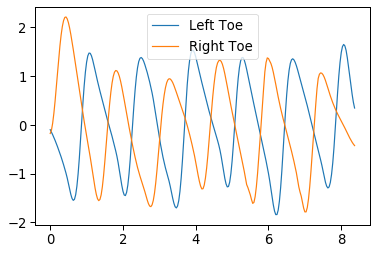

In [20]:
dfout.plot()

In [24]:
dfout.interpolate()

,Left Toe,Right Toe
0.000000,0.021712,-0.265583
0.033333,-0.060767,-0.262480
0.066667,-0.127815,-0.131560
0.100000,-0.202263,0.297195
0.133333,-0.270614,0.725950
...,...,...
8.233333,0.827100,-0.104801
8.266667,0.636130,-0.104801
8.300000,0.458300,-0.104801
8.333333,0.270431,-0.104801


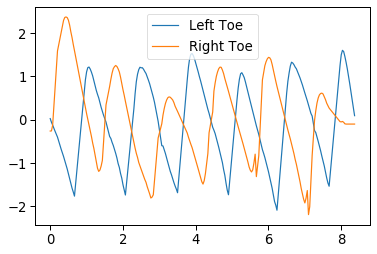

In [22]:
# dfout.interpolate(method='linear').plot() #simple linear interpolation 

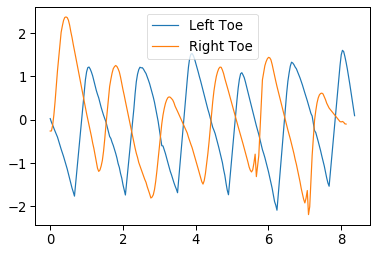

In [78]:
dfout.interpolate(method='cubic').plot() #simple linear interpolation 

In [31]:
df = poses.get_joint_data(joints)
s = (df.loc[:,(joints,['x','likelihood'])]).copy()
s.columns = s.columns.droplevel(0)
s = s.loc[s.likelihood > 0.8]
x = s.x #use x-trajectory

ValueError: Cannot index with multidimensional key

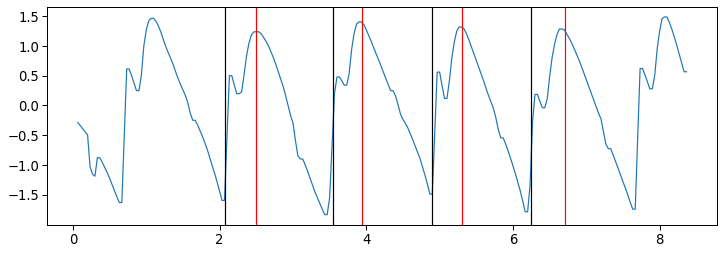

In [308]:
dfout['Left Toe'].plot(figsize=(12,4))
for to,hs in zip(truth.LTO, truth.LHS):
    plt.axvline(x=to,c='k')
    plt.axvline(x=hs,c='r')
    
# plt.scatter(truth.RTO,dfout.loc[truth.RTO.values])

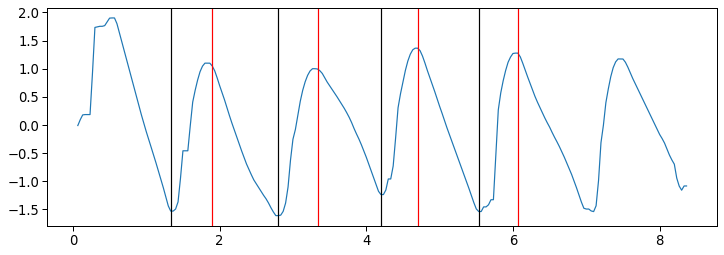

In [300]:
dfout['Right Toe'].plot(figsize=(12,4))
for to,hs in zip(truth.RTO, truth.RHS):
    plt.axvline(x=to,c='k')
    plt.axvline(x=hs,c='r')
    
# plt.scatter(truth.RTO,dfout.loc[truth.RTO.values])

In [66]:
# #weighted mean simulation
# x = np.array([1,2,3,4,5])
# w = np.array([0.2,0.01,0.6,0.1,0.9])
# mu = (np.mean(x))
# w_mu = (np.dot(x,w)/np.sum(w))
# plt.scatter(x,np.zeros(len(x)),s=100*w)
# plt.scatter(mu,1,c='k',s=100,alpha=.4)
# plt.scatter(w_mu,0.5,c='r',s=200,alpha=.4)

Left Toe
Right Toe


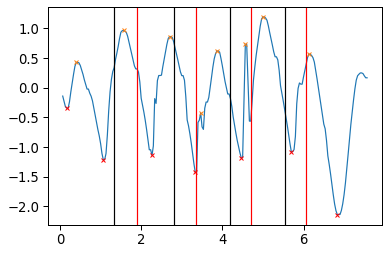

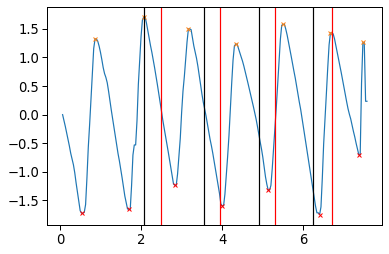

In [245]:
%matplotlib inline
SWST_all = []
# Filter = FilterData()
# dfout = Filter.get_filterdata(poses,joints) #the filtered poses
for side in dfout.columns:
    print(side)
    szf = dfout[side]
    pksT,pksNT = findHSTO(szf,direction) #find positive and neg peaks (approx HS, TO)
    swst = swing_stance(pksT,pksNT) # swing and stance times
    #add metadata
    swst['side'] = side.split(' ')[0]
    subjid = '_'
    l = filename.split('_')[0:4]
    subjid = subjid.join(l)
    swst['subj'] = subjid

    #plot groundtruth
    if side.split(' ')[0] == 'Right':
        for to,hs in zip(truth.RTO, truth.RHS):
            plt.axvline(x=to,c='k')
            plt.axvline(x=hs,c='r')
    else:
        for to,hs in zip(truth.LTO, truth.LHS):
            plt.axvline(x=to,c='k')
            plt.axvline(x=hs,c='r')

    
    SWST_all.append(swst)    
   

In [247]:
SWST_all = pd.concat(SWST_all)

In [248]:
SWST_all.query('side=="Left"')


,dT,type,Type,side,subj
0,0.233333,1.0,Swing,Left,SS02_3FU_SSV3_Brace
1,0.666667,-1.0,Stance,Left,SS02_3FU_SSV3_Brace
2,0.500000,1.0,Swing,Left,SS02_3FU_SSV3_Brace
3,0.700000,-1.0,Stance,Left,SS02_3FU_SSV3_Brace
4,0.433333,1.0,Swing,Left,SS02_3FU_SSV3_Brace
5,0.633333,-1.0,Stance,Left,SS02_3FU_SSV3_Brace
6,0.133333,1.0,Swing,Left,SS02_3FU_SSV3_Brace
7,0.400000,0.0,Missed,Left,SS02_3FU_SSV3_Brace
8,0.600000,-1.0,Stance,Left,SS02_3FU_SSV3_Brace
9,0.100000,1.0,Swing,Left,SS02_3FU_SSV3_Brace


In [130]:
SWST_all.query('side=="Left" & Type=="Swing"')

,dT,type,Type,side,subj
2,0.100000,1.0,Swing,Left,SS02_3FU_SSV3_Brace
5,0.100000,1.0,Swing,Left,SS02_3FU_SSV3_Brace
8,0.466667,1.0,Swing,Left,SS02_3FU_SSV3_Brace
10,0.400000,1.0,Swing,Left,SS02_3FU_SSV3_Brace
12,0.133333,1.0,Swing,Left,SS02_3FU_SSV3_Brace
15,0.100000,1.0,Swing,Left,SS02_3FU_SSV3_Brace


In [119]:
side = 'Left'
dfout[side + ' Toe'].plot() 

Heel

In [103]:
pksT

Float64Index([1.3333333333333333, 3.1333333333333333,                4.9,
                             6.5,                8.1,                9.7,
              11.266666666666667, 12.733333333333333],
             dtype='float64')

In [104]:
pksNT

Float64Index([0.8333333333333334,                2.6,  4.466666666666667,
               6.066666666666666,                7.6,  9.233333333333333,
                            10.8,               12.4],
             dtype='float64')

Toe

In [21]:
pksT

Float64Index([               1.4,                3.1,                4.9,
               6.466666666666667,                8.1,                9.7,
              11.333333333333334, 12.766666666666667],
             dtype='float64')

In [22]:
pksNT

Float64Index([0.9666666666666667,                2.7,  4.566666666666666,
                             6.1,                7.7,  9.333333333333334,
              10.866666666666667, 12.466666666666667],
             dtype='float64')

In [98]:

SWST_all=pd.concat(SWST_all)

In [306]:
swst_all = pd.concat(swst_all)

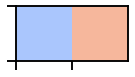

In [317]:
sns.palplot(sns.color_palette("coolwarm", 2))

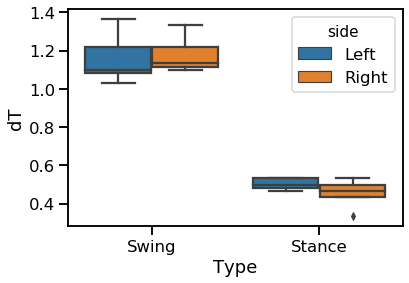

In [99]:
# from pylab import *
# cmap = cm.get_cmap(sns.color_palette("coolwarm", 2))
sns.boxplot(x='Type',y='dT',data=SWST_all, hue='side')

# One-Off Filtering

In [12]:
# joints =['Left Heel','Left Toe'] #make a copy of the data
joints =['Left Heel','Left Toe','Right Heel','Right Toe'] #make a copy of the data
df = poses.get_joint_data(joints)

In [21]:
s

0.000000    353.501984
0.033333    363.972534
0.066667    398.275330
0.300000    808.491028
0.333333    845.736206
               ...    
8.000000    557.535706
8.033333    541.685974
8.066667    519.337891
8.100000    492.767090
8.133333    470.889557
Name: x, Length: 224, dtype: float64

In [16]:
%matplotlib qt

p_cutoff = .6
# j = 'Right Heel'
j = 'Right Toe'
# j = 'Left Heel'
# j = 'Left Toe'

s = (df.loc[:,(j,['x','likelihood'])]).copy()
s.columns = s.columns.droplevel(0)
s['time'] = s.index
plt.plot(s['time'],s.x)
sns.scatterplot(x='time',y='x',data=s, hue='likelihood', legend=False)

s = s.loc[s.likelihood > p_cutoff]
s.x = s.x.interpolate(method='cubic')
plt.plot(s['time'],s.x)

# likelihood = s.likelihood
s = s.x

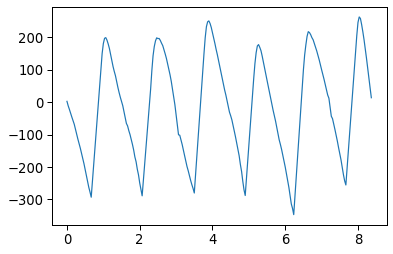

In [268]:
#high pass filter 
sos_filt = butter(8, 0.25, 'highpass', fs=30, output='sos')
x = sosfiltfilt(sos_filt,s.values)
s_filt = pd.Series(data=x, index=s.index)
s_filt.plot()
s = s_filt.copy()

### z-score and remove outliers

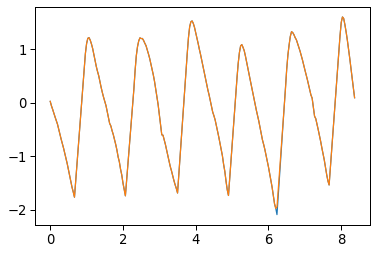

In [269]:
NZ = Normalizer()
s = NZ.zscore(s)
sz = NZ.removeOutliers(s,interp=True)
s.plot()
sz.plot()

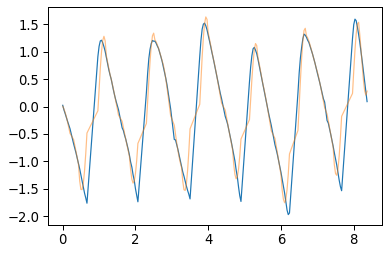

In [270]:
#interpolate with savgol filter
x = signal.savgol_filter(sz.values, 15, 3)
sz.plot()
pd.Series(data=x, index=sz.index).plot(alpha=.5)

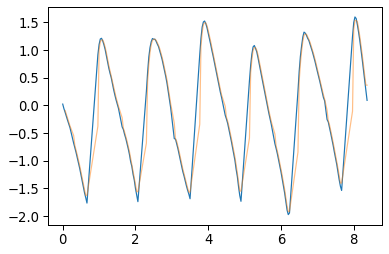

In [271]:
#remove detection noise with median filter
szf = sz.rolling(4, center=True).median().interpolate().dropna()
# szf = sz.rolling(10, center=True).mean().interpolate().dropna()
# szf = sz.rolling(10, center=True).median().rolling(10, center=True).mean().interpolate().dropna()
sz.plot()
szf.plot(alpha=.5)

# A crude separation of swing vs stance
* find maxima and minima - compute derivative and find 0 crossings 
* compute 2nd derivative to determine if swing or stance
* extract swing and stance time for each person and side

* perhaps we can use the ankle angle and angular speed to determine if its HS or TO

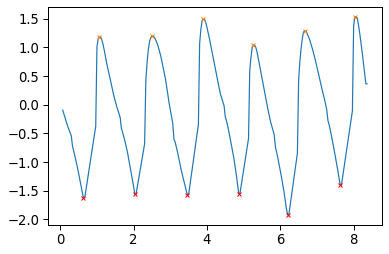

In [272]:
pks,_ = find_peaks(szf,distance=10, prominence=0.1)
szf.plot()
pksT = szf.index[pks]
plt.plot(pksT,szf.iloc[pks],'x')
pksN,_ = find_peaks(szf*-1, distance=10, prominence=0.1)
pksNT = szf.index[pksN]
plt.plot(pksNT,szf.iloc[pksN],'x',c='r')


In [273]:
def swing_stance(pksT,pksNT):
    
    minswingT = 0.05
    maxstanceT = 3
    
    T = list(pksT.values)+list(pksNT.values)
    S = list(np.ones_like(pksT))+list(np.zeros_like(pksNT))
    T_sorted = np.sort(T)
    inds_sorted = np.argsort(T)
    S = [S[i] for i in inds_sorted]
    #swings are -1; stances are 1; missed are 0    
    swst = pd.DataFrame({'dT':np.diff(T_sorted), 'type':np.diff(S)})
    swst['Type'] = 'Missed'
    swst.loc[swst.type==-1,'Type']='Swing'
    swst.loc[swst.type==1,'Type']='Stance'
    swst.loc[(swst.dT > maxstanceT) | (swst.dT <minswingT),'Type'] = 'Missed'
    
    return swst

In [274]:
swst = swing_stance(pksT,pksNT)

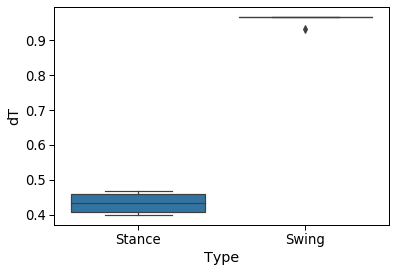

In [275]:
sns.boxplot(x='Type',y='dT',data=swst)

In [282]:
swst.query("Type=='Stance'")

,dT,type,Type
0,0.433333,1.0,Stance
2,0.466667,1.0,Stance
4,0.433333,1.0,Stance
6,0.400000,1.0,Stance
8,0.466667,1.0,Stance
10,0.400000,1.0,Stance


In [130]:
HS = np.sort(list(pksT.values))
TO = np.sort(list(pksNT.values))
swingT = []
stanceT = []
minT= .1 #min time between swing/stance
maxT = 3 #max time

for i,hs in enumerate(HS):

    #is there a preceding swing?
    if TO[i] < hs:
        swing = hs-TO[i]
        if swingT < maxT: #is within the allotted time?
            swingT.append(swing)
            
    #is there a subsequent stance?
    try:
        if (TO[i+1] > hs):
            stance = TO[i+1]-hs
            if (stance > minT) and (stance < maxT):
                stanceT.append(stance)
    except:
        print('end of list reached')    

[ 0.26666667  1.4         2.76666667  4.          5.4         6.73333333
  8.03333333  9.36666667 10.7       ]
[0.63333333 1.9        3.2        4.5        5.86666667 7.23333333
 8.56666667 9.83333333]


In [148]:
HSTO = [list(HS),list(TO)]
swing_stance(HSTO)

0 0.26666666666666666


([], [1.6333333333333333])

In [150]:
HS

array([ 0.26666667,  1.4       ,  2.76666667,  4.        ,  5.4       ,
        6.73333333,  8.03333333,  9.36666667, 10.7       ])

In [176]:
T = list(pksT.values)+list(pksNT.values)
S = list(np.ones_like(pksT))+list(np.zeros_like(pksNT))
T_sorted = np.sort(T)
inds_sorted = np.argsort(T)
S = [S[i] for i in inds_sorted]

In [177]:
print(T_sorted, S)

[ 0.26666667  0.63333333  1.4         1.9         2.76666667  3.2
  4.          4.5         5.4         5.86666667  6.73333333  7.23333333
  8.03333333  8.56666667  9.36666667  9.83333333 10.7       ] [1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]


In [184]:
np.diff(S)

array([-1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
        1., -1.,  1.])

In [205]:
#swings are -1; stances are 1; missed are 0
swst = pd.DataFrame({'dT':np.diff(T_sorted), 'type':np.diff(S)})
SwingT = swst.query('type==-1').dT
StanceT = swst.query('type==1').dT

In [206]:
swst

,dT,type
0,0.366667,-1.0
1,0.766667,1.0
2,0.500000,-1.0
3,0.866667,1.0
4,0.433333,-1.0
5,0.800000,1.0
6,0.500000,-1.0
7,0.900000,1.0
8,0.466667,-1.0
9,0.866667,1.0


In [211]:
swst['Type'] = 'missed'
swst.loc[swst.type==-1,'Type']='Swing'
swst.loc[swst.type==1,'Type']='Stance'
swst.drop('type',axis=1,inplace=True)

In [212]:
swst

,dT,Type
0,0.366667,Swing
1,0.766667,Stance
2,0.500000,Swing
3,0.866667,Stance
4,0.433333,Swing
5,0.800000,Stance
6,0.500000,Swing
7,0.900000,Stance
8,0.466667,Swing
9,0.866667,Stance


In [191]:
StanceT

1     0.766667
3     0.866667
5     0.800000
7     0.900000
9     0.866667
11    0.800000
13    0.800000
15    0.866667
Name: dT, dtype: float64

In [128]:
HSTO = list(pksT.values)+list(pksNT.values)
HSTO = np.sort(HSTO)
HSTO

array([ 0.26666667,  0.63333333,  1.4       ,  1.9       ,  2.76666667,
        3.2       ,  4.        ,  4.5       ,  5.4       ,  5.86666667,
        6.73333333,  7.23333333,  8.03333333,  8.56666667,  9.36666667,
        9.83333333, 10.7       ])

In [124]:
HS.values

array([ 0.26666667,  1.4       ,  2.76666667,  4.        ,  5.4       ,
        6.73333333,  8.03333333,  9.36666667, 10.7       ])

In [118]:
for hs,to in zip(HS,TO):
    #is there a preceding TO?
    
    print(hs,to)

0.26666666666666666 0.6333333333333333
1.4 1.9
2.7666666666666666 3.2
4.0 4.5
5.4 5.866666666666666
6.733333333333333 7.233333333333333
8.033333333333333 8.566666666666666
9.366666666666667 9.833333333333334


In [114]:
#stance

HS = pksT
TO = pksNT
print(HS,TO)

Float64Index([0.26666666666666666,                 1.4,  2.7666666666666666,
                              4.0,                 5.4,   6.733333333333333,
                8.033333333333333,   9.366666666666667,                10.7],
             dtype='float64') Float64Index([0.6333333333333333,                1.9,                3.2,
                             4.5,  5.866666666666666,  7.233333333333333,
               8.566666666666666,  9.833333333333334],
             dtype='float64')


In [115]:
np.abs(HS-TO)

ValueError: cannot evaluate a numeric op with unequal lengths

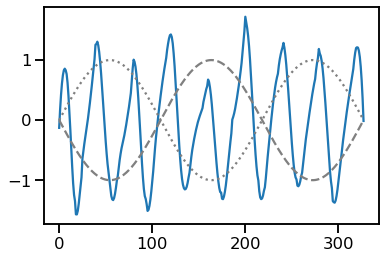

In [103]:

border = np.sin(np.linspace(0, 3 * np.pi, x.size))
peaks, _ = find_peaks(x, height=(-border, border))
plt.plot(x)
plt.plot(-border, "--", color="gray")
plt.plot(border, ":", color="gray")
plt.plot(peaks, x[peaks], "x")
plt.show()

### moving average filter 

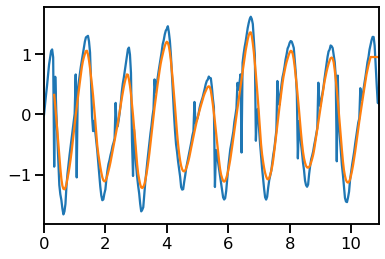

In [79]:
sz.plot()
# szf = sz.rolling(10, center=True).median().interpolate().dropna()
szf = sz.rolling(10, center=True).median().rolling(10, center=True).mean().interpolate().dropna()
szf.plot()

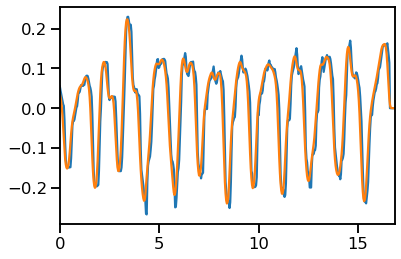

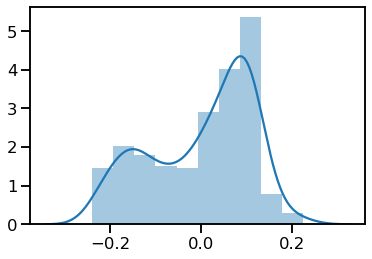

In [30]:
s_dot = szf.diff().dropna()
s_dot.index -= s_dot.index[0]
s_dot.plot()
x = signal.savgol_filter(s_dot, 9, 3)
s_dot_filt = pd.Series(data=x, index=s_dot.index).rolling(5,center=True).mean().interpolate().dropna()
s_dot_filt.index -= s_dot_filt.index[0]
s_dot_filt.plot()
plt.figure()
sns.distplot(s_dot_filt)

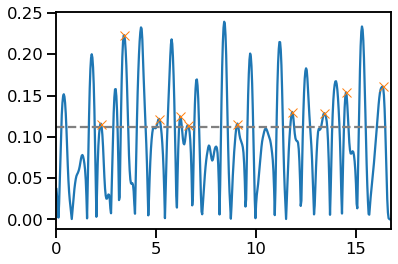

In [306]:
s_dot_filt.apply(abs).plot() 
rms = np.sqrt(np.mean(s_dot_filt**2))
plt.axhline(rms,c='gray',linestyle='--')
pks, _ = find_peaks(s_dot_filt, height=rms)
pksT = s_dot_filt.index[pks]
plt.plot(pksT,s_dot_filt.iloc[pks],'x')

In [219]:
s_dot_filt

0.000000    -0.020755
0.033333    -0.030620
0.066667    -0.049195
0.100000    -0.085263
0.133333    -0.130082
               ...   
17.833333    0.000619
17.866667    0.000397
17.900000    0.000222
17.933333    0.000222
17.966667    0.000222
Length: 540, dtype: float64

In [113]:
#high pass filter 
from scipy.signal import decimate, butter, sosfiltfilt, find_peaks
sos_filt = butter(4, 0.1, 'highpass', fs=30, output='sos')
x = sosfiltfilt(sos_filt,sz.values)
sz_filt = pd.Series(data=x, index=sz.index)

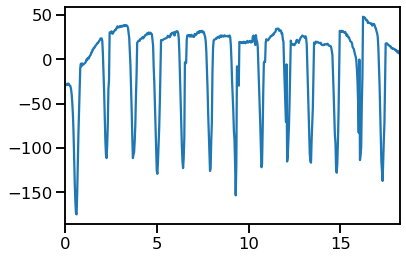

In [114]:
sz_filt.plot()

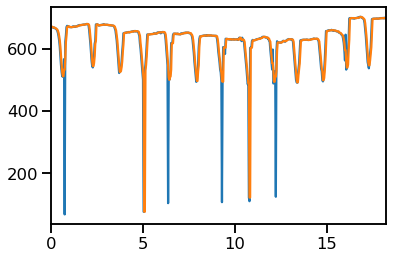

In [19]:
#try moving average filters - issue of delay
j = 'Left Heel'
s = (df.loc[:,(j,['x','y'])]).copy()
s.columns = s.columns.droplevel(0)
s.loc[:,'y'].plot()
s.rolling(3).median().loc[:,'y'].plot()

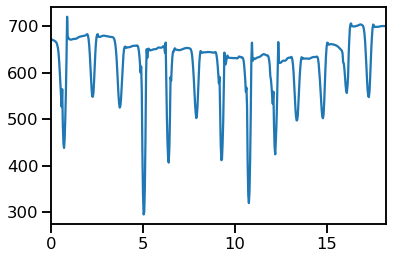

In [131]:
#the savgol filter fails here since it accentuates peaks corresponding to outliers
sfilt = s.copy()
for i in range(len(sfilt.columns)):
    sfilt.iloc[:,i] = signal.savgol_filter(s.iloc[:,i],9,3)\
sfilt['y'].plot()

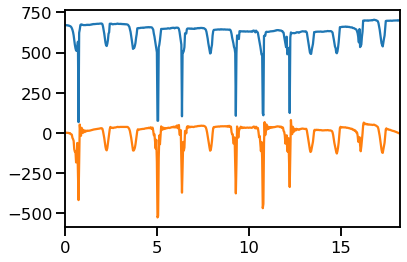

In [143]:
#try a standard bandpass filter
Fs = np.mean(np.diff(df.index)**(-1))
b,a = signal.butter(5, [0.1,10], btype='bandpass',fs=Fs, output='ba')

sfilt = s.copy()
for i in range(len(sfilt.columns)):
    sf = signal.filtfilt(b, a, sfilt.iloc[:,i])
    sfilt.iloc[:,i] = sf
    
s.loc[:,'y'].plot()
sfilt['y'].plot()

In [59]:
df = poses.get_joint_data(joints).copy()           
#            df_i = df_i.loc[:,(j, ['x','y','likelihood'])]
df.loc[:,'Left Heel'].columns

Index(['x', 'y', 'likelihood'], dtype='object', name='coords')

In [16]:
matplotlib.use('Agg')
for filename in posefiles:
    print(filename)
    poses = PoseData(path, filename)
    joints = poses.get_joint_names()
    jointsnew = [] #reorder joint names
    for i in range(5):
        jointsnew.append(joints[i::5])
    jointsnew=list(itertools.chain(*jointsnew))
    PA = AnalyzePoses(jointsnew)
    PA.plot_joints(poses, savepath=path+'/Figs/')
    plt.close()

SS07_Pre_SSV2_No Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle2_200000.h5
10
SS04_Mid_SSV3_Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle2_200000.h5
10
SS07_Pre_SSV2_No Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle1_80000.h5
10
SS07_Pre_SSV2_No Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle0_80000.h5
10
SS04_Mid_SSV3_Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle1_80000.h5
10
SS04_Mid_SSV3_Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle0_80000.h5
10


10


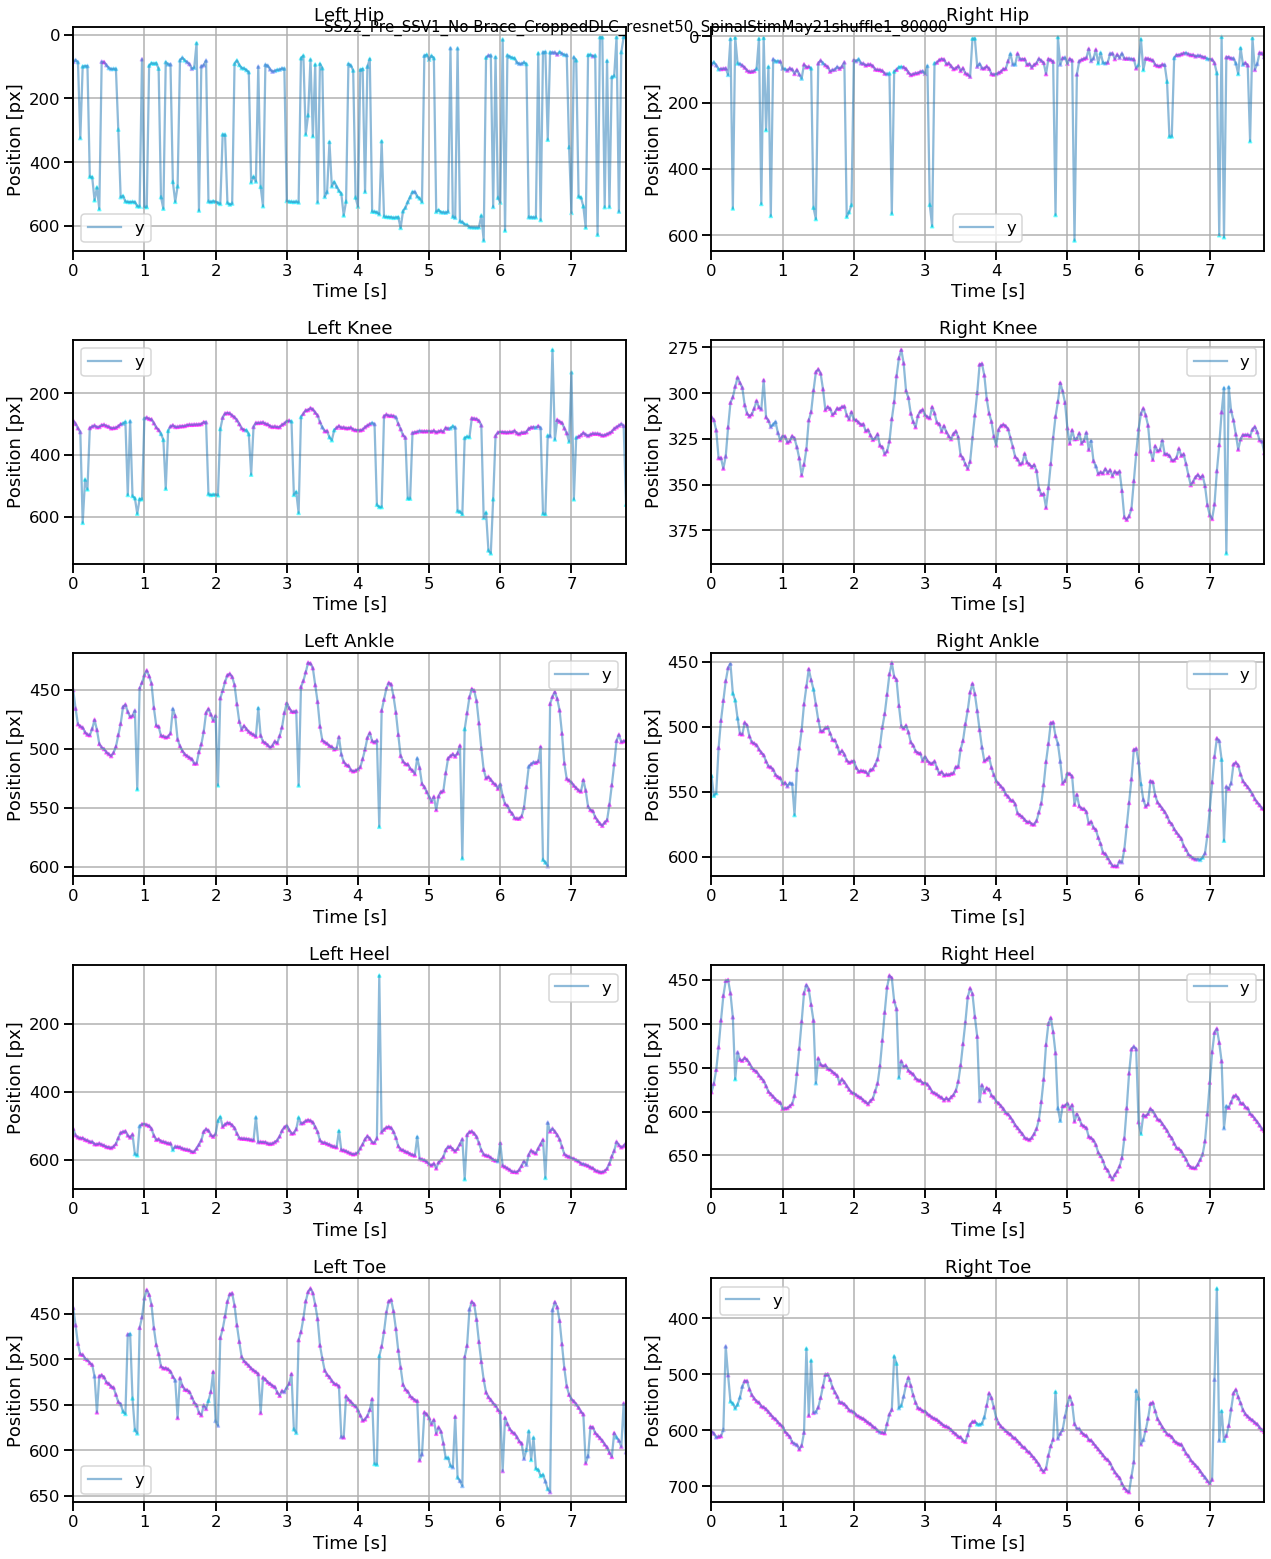

In [12]:
poses = PoseData(path, filename)

joints = poses.get_joint_names()
jointsnew = [] #reorder joint names
for i in range(5):
    jointsnew.append(joints[i::5])
joints=list(itertools.chain(*jointsnew))

PA = AnalyzePoses(joints)
PA.plot_joints(poses)

In [16]:
poses.get_joint_data()

bodyparts     Left Hip                          Left Knee              \
coords               x           y likelihood           x           y   
0.000000    681.544128   84.718163   0.255434  663.912170  288.993042   
0.033333    687.619141   79.436012   0.151803  664.908020  299.494659   
0.066667    688.623779   85.698555   0.094302  659.417419  313.813141   
0.100000    616.610413  324.797516   0.041012  645.685425  326.076447   
0.133333    693.252747   99.318825   0.042345  473.251740  619.131775   
...                ...         ...        ...         ...         ...   
7.633333   1086.910034    7.194415   0.028174  570.197510  310.300446   
7.666667    679.870605  556.003784   0.043662  563.601929  304.981995   
7.700000    711.166504   54.355717   0.042059  563.488586  299.939484   
7.733333   1069.987061    6.765538   0.040275  577.134216  306.136261   
7.766667   1067.535889    6.268263   0.019616  633.225708  560.632324   

bodyparts             Left Ankle                          Left Heel  ...  \
coords    likelihood           x           y likelihood           x  ...   
0.000000    0.990079  688.793213  450.032776   0.994650  684.113464  ...   
0.033333    0.991371  688.300842  465.809692   0.997729  677.164612  ...   
0.066667    0.994959  690.034912  479.075134   0.999014  668.865723  ...   
0.100000    0.759540  683.594604  480.852631   0.998924  655.301086  ...   
0.133333    0.014135  671.591797  481.948456   0.999261  642.782959  ...   
...              ...         ...         ...        ...         ...  ...   
7.633333    0.998612  485.362946  493.159119   0.890524  427.420197  ...   
7.666667    0.968475  497.063965  487.933716   0.939615  453.579132  ...   
7.700000    0.782967  516.433655  494.071503   0.973068  483.692841  ...   
7.733333    0.846981  543.015076  493.424591   0.992703  516.847168  ...   
7.766667    0.021468  568.809082  492.841705   0.996878  548.871155  ...   

bodyparts Right Knee Right Ankle                         Right Heel  \
coords    likelihood           x           y likelihood           x   
0.000000    0.995215  464.425140  537.911133   0.026160  396.684357   
0.033333    0.993947  378.973785  553.153015   0.037106  378.592407   
0.066667    0.985248  380.710541  551.187134   0.041341  366.527863   
0.100000    0.957284  453.104126  516.406677   0.903433  379.535431   
0.133333    0.993400  470.520142  495.437897   0.995392  400.073517   
...              ...         ...         ...        ...         ...   
7.633333    0.924204  688.753723  555.789185   0.997622  642.202820   
7.666667    0.957804  675.202637  558.346436   0.998166  628.476135   
7.700000    0.987422  662.067810  560.444031   0.993518  616.513123   
7.733333    0.836718  648.441223  562.922485   0.989708  601.859619   
7.766667    0.827787  635.563049  563.296021   0.980230  588.447571   

bodyparts                          Right Toe                         
coords              y likelihood           x           y likelihood  
0.000000   577.975525   0.991926  534.704407  602.092041   0.968319  
0.033333   568.371460   0.964170  518.337341  606.120361   0.821814  
0.066667   552.401245   0.988367  499.570374  612.939636   0.540846  
0.100000   526.854126   0.982338  486.675201  611.730591   0.978617  
0.133333   496.195435   0.998888  477.517365  610.808899   0.997385  
...               ...        ...         ...         ...        ...  
7.633333   608.449341   0.999104  778.995178  586.738525   0.997351  
7.666667   611.843201   0.997818  766.460327  589.522156   0.975033  
7.700000   615.803040   0.995790  754.261230  595.624329   0.984195  
7.733333   619.970520   0.995917  743.999817  599.810181   0.989411  
7.766667   621.940369   0.995201  731.613647  602.999573   0.994007  

[234 rows x 30 columns]

## Test data

In [7]:
path = '/home/l_lonini01/SpinalStim/DLC/SpinalStim--2020-06-25/test-comparison/'
posefiles=[c for c in os.listdir(path) if c.endswith('.h5')]
filename = posefiles[0]
filename

'SS06_Post_SSV2_Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle0_100000.h5'

In [8]:
path

'/home/l_lonini01/SpinalStim/DLC/SpinalStim--2020-06-25/test-comparison/'

In [9]:
matplotlib.use('Agg')
os.makedirs(path+'/Figs', exist_ok=True)
for filename in posefiles:
    print(filename)
    poses = PoseData(path, filename)
    joints = poses.get_joint_names()
    jointsnew = [] #reorder joint names
    for i in range(5):
        jointsnew.append(joints[i::5])
    jointsnew=list(itertools.chain(*jointsnew))
    PA = AnalyzePoses(jointsnew)
    PA.plot_joints(poses, savepath=path+'/Figs/')
    plt.close()

SS06_Post_SSV2_Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle0_100000.h5
10
SS02_3FU_SSV1_Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle0_100000.h5
10
SS07_Pre_SSV1_Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle0_100000.h5
10
SS07_Post_SSV1_No Brace_CroppedDLC_resnet50_SpinalStimMay21shuffle0_100000.h5
10


10


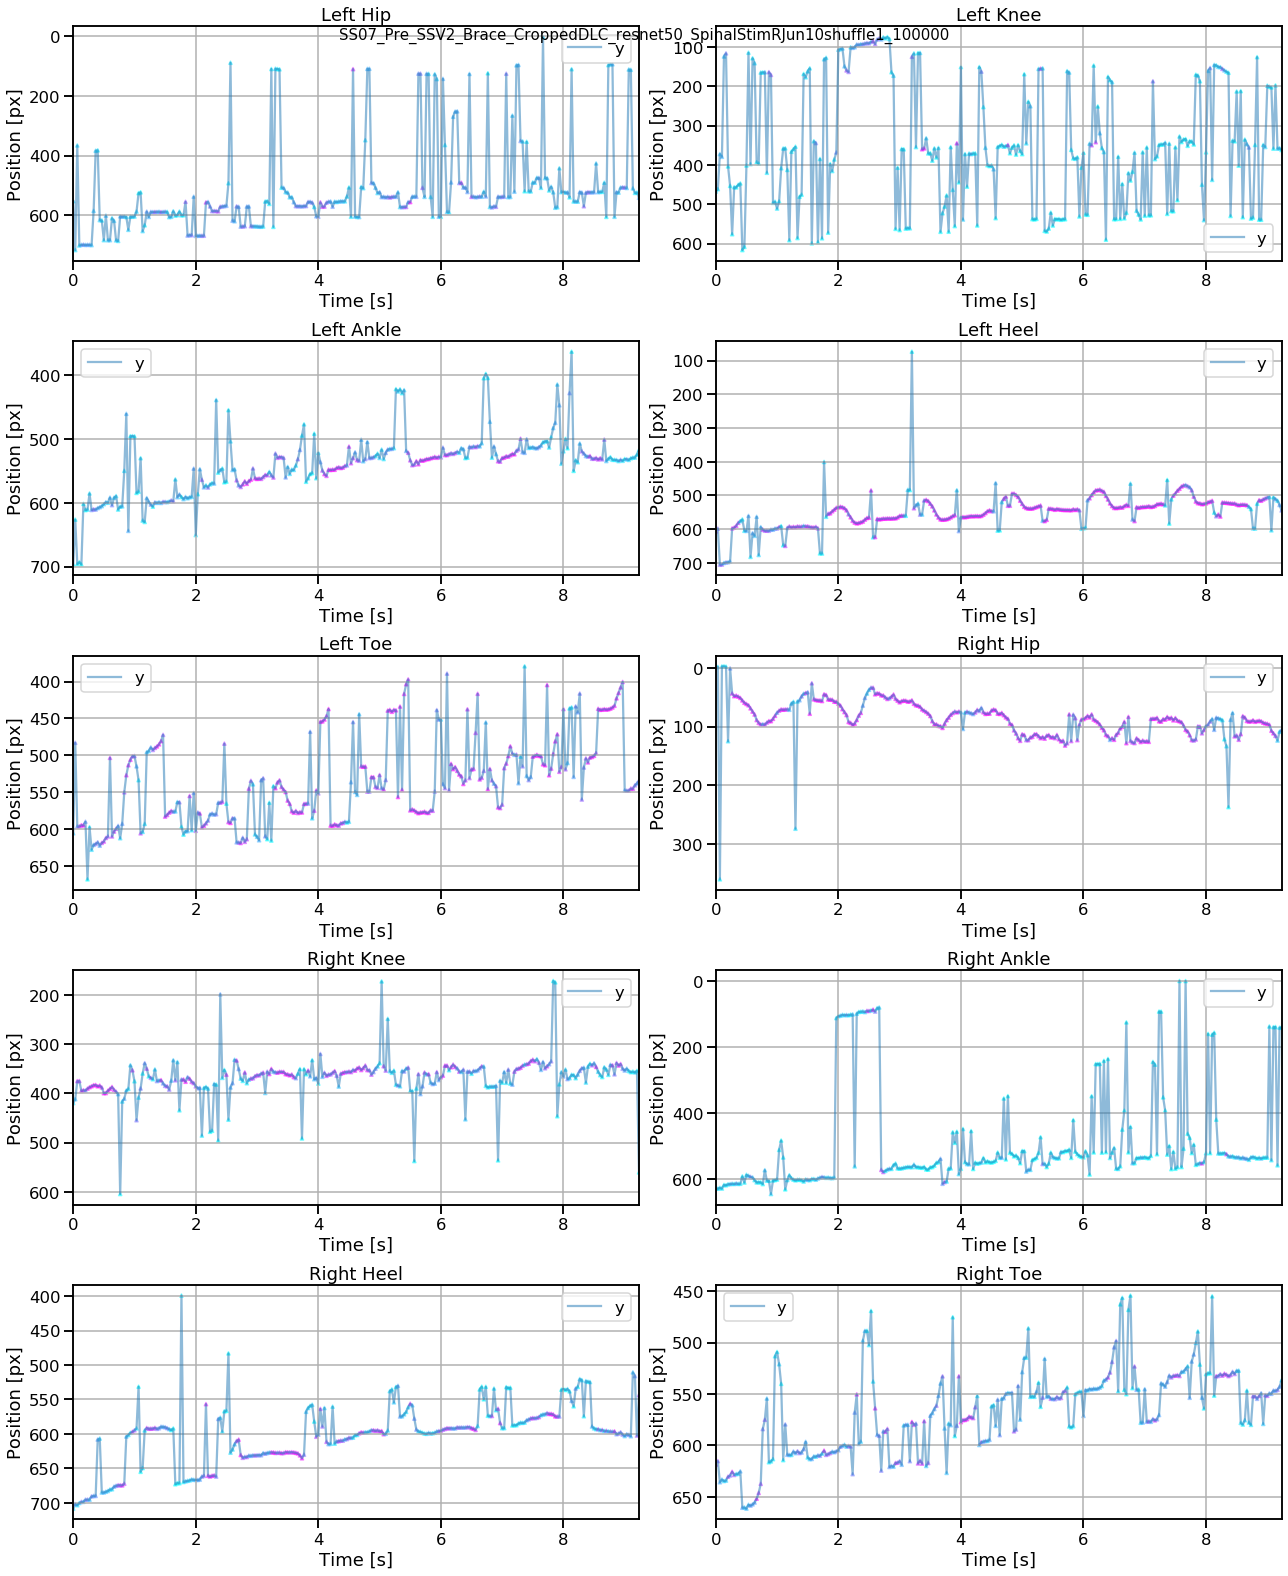

In [8]:
%matplotlib inline
poses = PoseData(path, filename)
joints = poses.get_joint_names()
PA = AnalyzePoses(joints)
PA.plot_joints(poses)

10


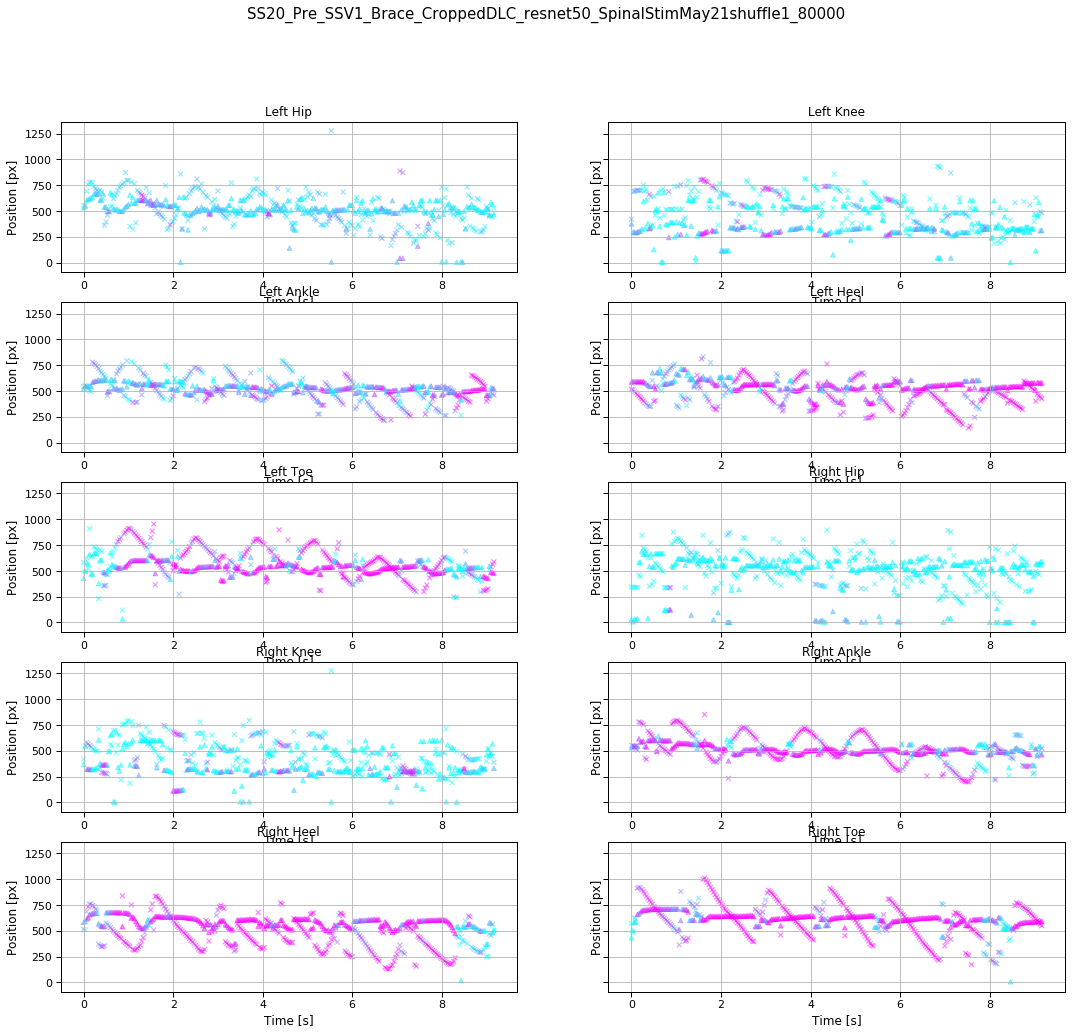

In [89]:
poses = PoseData(path, filename)
joints = poses.get_joint_names()
PA = AnalyzePoses(joints)
PA.plot_joints(poses)